In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
np.set_printoptions(threshold=np.inf)

In [394]:
# Constants
hbar = 1.0   # Planck's constant / 2π
m = .1
R = 3E4
U = .01
distance = (R)*5
earth_cutoff = R / distance

# Based on the condition given in equation 3, the eigenvalue k^2 << (m*U)^3/2 * R in order for there to be a large asymmetry
k_condition = (m*U)**(3/2) * R
print("k squared condition: ", k_condition)
#For tomorrow - graph eigenvalues much greater and lower than the condition and see how asymmetry happens
print((m * 1E-14)**(3/2) * 3.2E13)

#kr should be order 1, delta should be order 1, with k = 1E-4
# use this to vary the kr >> 1 whatever it was
# only think about the inequality in terms of k = 1E-4
# if we're doing a FD cutoff, use like 1E-3

# delta negative is neutrino, delta positive is anti-neutrino

# scale earth down a lot to like a few meters, scale k down as well but like not as small compared to earth as it currently is
# base these values off equation 3
#make it very followed and very violated and see what happens as a toy model

# make sure that our largest eigenvalue has to be much greater than 10^-8 (which is k^2) because that allows us to just use the values
# that represent the CnuB IRL
# this can give us a sense of how many points/distance to use actually :)

#actual values:
# R = 3.2E13 1/ev
# U = 1E-14

k squared condition:  0.9486832980505139
1.0119288512538816e-09


In [29]:
# define derivative matrices

def first_deriv(N, r):
    diags0 = np.zeros(N)

    ddr = np.diag(diags0)

    for i in range(0, ddr.shape[0]):
        if i != 0:
            ddr[i,i-1] = -1
        if i != ddr.shape[0]-1:
            ddr[i,i+1] = 1
    
    delta_x = r[1] - r[0]

    return ddr / (2 * delta_x)



def second_deriv(N, r):
    diags2 = np.full(N, 2)

    d2dr = np.diag(diags2)

    for i in range(0, d2dr.shape[0]):
        if i != 0:
            d2dr[i,i-1] = -1
        if i != d2dr.shape[0]-1:
            d2dr[i,i+1] = -1

    delta_x =  r[1] - r[0]
    return d2dr / (delta_x**2)

# second_deriv(5, [1, 2, 3, 4, 5])

# This should be the finite difference matrix for the second derivative generalized to non-uniformly spaced points
# def second_deriv(N, r):
#     d2dr = np.zeros((N, N))

#     for i in range(0, d2dr.shape[0]):
#         if i != 0 and i != d2dr.shape[0]-1:
#             d2dr[i,i] = 2 / ((r[i+1] - r[i]) * (r[i] - r[i-1]))
#             d2dr[i,i-1] = -2 / ((r[i] - r[i-1]) * (r[i+1] - r[i-1]))
#             d2dr[i,i+1] = -2 / ((r[i+1] - r[i]) * (r[i+1] - r[i-1]))
#         elif i ==0:
#             d2dr[i,i] = 2 / ((r[i+1] - r[i])**2)
#             d2dr[i,i+1] = -1 / ((r[i+1] - r[i])**2)
#         else:
#             d2dr[i,i] = 2 / ((r[i] - r[i-1])**2)
#             d2dr[i,i-1] = -1 / ((r[i] - r[i-1])**2)
        
#     print("\n\n\n\n")
#     return d2dr

# second_deriv(5, [1, 2, 3, 4, 5])


def normalize(psi):
    norm = np.sqrt(np.sum(np.abs(psi)**2))  # Compute the norm of the vector
    psi_norm = psi / norm  # Normalize the vector
    return psi_norm


In [30]:
# Potentials and Hamiltonian from equation 25


def potential_nu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        
        V_eff_in = (l * (l + 1))/(r[i]**2) + 2 * m * U

        # outside the earth:
        V_eff_out = (l * (l + 1))/(r[i]**2)

        if r[i] < R:
            H[i,i] = V_eff_in
        else:
            H[i,i] = V_eff_out

    return H

def potential_antinu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        V_eff_in_neg = (l * (l + 1))/(r[i]**2) - 2 * m * U

        # outside the earth:
        V_eff_out_neg = (l * (l + 1))/(r[i]**2)
        #print("In, Out neg: ", V_eff_in_neg, V_eff_out_neg)

        if r[i] < R:
            H[i,i] = V_eff_in_neg
        else:
            H[i,i] = V_eff_out_neg
    return H

# create the equation to be solved: Hψ = (k^2)ψ
def Hamiltonian_nu_25(N, r, l):
    H = - second_deriv(N, r) + potential_nu_25(N,r, l)
    return H

def Hamiltonian_antinu_25(N, r, l):
    H = - second_deriv(N, r) + potential_antinu_25(N,r, l)
    return H


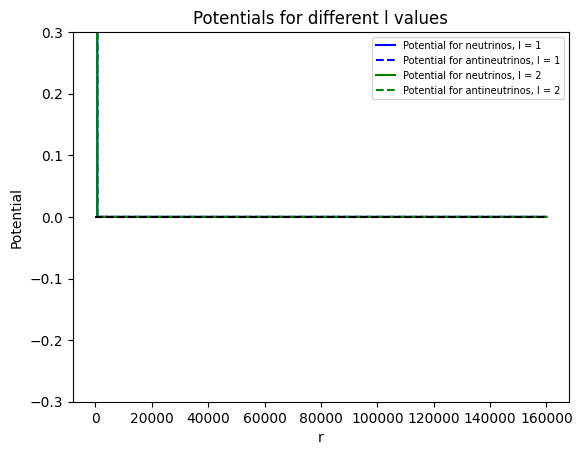

In [31]:
def plot_potentials(N, l_values):
    
    linspace1 = np.linspace(0.001, R, int(.5*N)+1)
    linspace2 = np.linspace(R, distance, int(.5*N))
    r_values = np.unique(np.concatenate((linspace1, linspace2)))
    
    # Create a list of colors for the different l values
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, l in enumerate(l_values):
        # Calculate the potential matrices
        potential_nu = potential_nu_25(N, r_values, l)
        potential_antinu = potential_antinu_25(N, r_values, l)

        # Extract the diagonal values
        V_nu = np.diag(potential_nu)
        V_antinu = np.diag(potential_antinu)

        # Plot the potentials
        plt.plot(r_values, V_nu, color=colors[i], label=f'Potential for neutrinos, l = {l}')
        plt.plot(r_values, V_antinu, color=colors[i], linestyle='dashed', label=f'Potential for antineutrinos, l = {l}')

    plt.xlabel('r')
    plt.ylabel('Potential')
    plt.yscale('linear')
    plt.ylim(-.3, .3)
    plt.title('Potentials for different l values')
    plt.hlines(3.9E-17, xmin=0, xmax=distance, linestyle='dashed', color='black')
    #plt.hlines(-4.9e-16, xmin=0, xmax=distance, linestyle='dashed', color='black')
    
    # Adjust legend size and position
    plt.legend(fontsize=7, loc='upper right')

    plt.savefig('1D_plots/potentials.png')
    plt.show()

# Call the function with a list of l values
plot_potentials(100, [1,2])

In [32]:
# function to graph the nth harmonic
#try solving equation 25 instead


def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(f'neutrino energy {n}:', E_pos[n-1])
    print(f'antineutrino energy {n}:', E_neg[n-1])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    # divide by r_values bc equation 25 defines phi = r*psi
    #Calculate the integral of the absolute square of psi/r over all space
    norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
    norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

    # Divide psi by the square root of this integral to renormalize
    psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
    psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)


    # Now plot the normalized functions
    ax1.plot(r_values, np.abs(psi_nu_normalized / r_values)**2, color = 'blue', label=f'Potential for neutrinos: n = {n}')
    ax1.plot(r_values, np.abs(psi_antinu_normalized / r_values)**2, color = 'green', label=f'Potential antineutrinos: n = {n}')

    # ax1.plot(r_values, np.abs(psi_pos[n-1] / r_values)**2, color = 'blue', label=f'Potential unchanged: n = {n}')
    # ax1.plot(r_values, np.abs(psi_neg[n-1] / r_values)**2, color = 'green', label=f'Potential negative: n = {n}')


    # Plot the asymmetry on the second subplot
    asym = []
    for i in range(0, len(r_values)):
        if np.abs(psi_nu_normalized[i] / r_values[i])**2 == np.abs(psi_antinu_normalized[i] / r_values[i])**2 and np.abs(psi_nu_normalized[i] / r_values[i])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(psi_nu_normalized[i] / r_values[i])**2 - np.abs(psi_antinu_normalized[i] / r_values[i])**2)/(np.abs(psi_nu_normalized[i] / r_values[i])**2 + np.abs(psi_antinu_normalized[i] / r_values[i])**2))
    ax2.plot(r_values, asym, color='red', label='Asymmetry') # graphing numerically
    
    # graph the potential on the same plot
    #ax1.vlines(3E13, ymin = 0, ymax=.001)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()


# harmonic(1, 1000, l=800000)
# harmonic(1, 2000, l=800000)
# harmonic(1, 3000, l=800000)

In [33]:
def harmonic_many_N(n, N_values, l):
    
    global r_values, psi_antinu, psi_nu
    

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    print("k^2 condition cutoff: ", k_condition)
    for i, N in enumerate(N_values):
        # linspace1 = np.linspace(0.001, R, int(N/2), endpoint=False)
        # linspace2 = np.linspace(R, distance, int(N/2))
        # r_values = np.unique(np.concatenate((linspace1, linspace2)))

        # Calculate the number of points in each segment
        N1 = int(N * R / distance)
        N2 = N - N1
        print(N1, N2)

        # Create linspace from 0.001 to R
        linspace1 = np.linspace(0.001, R, N1, endpoint=False)

        # Create linspace from R to distance
        linspace2 = np.linspace(R, distance, N2)

        # Concatenate the two linspaces to create the piecewise linspace
        r_values = np.linspace(0.001, distance, N)
        #r_values = np.concatenate((linspace1, linspace2))
        
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        print(E_pos)
        # print(E_neg)
        E_pos_within_range = np.count_nonzero((E_pos >= 1E-8) & (E_pos <= 1E-6))

        print(f'neutrino energy {n}:', E_pos[n-1])
        print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        psi_nu = (psi_nu.T) / (r_values)
        psi_antinu = (psi_antinu.T) / (r_values)
        psi_nu_normalized = normalize(psi_nu[n-1])
        psi_antinu_normalized = normalize(psi_antinu[n-1])


        print("probability: ", np.sum(np.abs(psi_nu_normalized)**2))
        # Now plot the normalized functions
        ax1.plot(r_values, np.abs(psi_nu_normalized)**2, label=f'probability for neutrinos: N = {N}')
        ax1.plot(r_values, np.abs(psi_antinu_normalized)**2,  linestyle='dashed', label=f'probability for antineutrinos: N = {N}')

        # Plot the asymmetry on the second subplot, defined as such to prevent dividing by zero
        asym = []
        for j in range(0, len(r_values)):
            if np.abs(psi_nu_normalized[j])**2 == np.abs(psi_antinu_normalized[j])**2 and np.abs(psi_nu_normalized[j])**2 == 0:
                asym.append(0)
            else:
                asym.append((np.abs(psi_nu_normalized[j])**2 - np.abs(psi_antinu_normalized[j])**2)/(np.abs(psi_nu_normalized[j])**2 + np.abs(psi_antinu_normalized[j])**2))
            
        print("first 5 asymmetry values: ", asym[:5], "\n")
        ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    
    
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')
    # ax1.set_ylim(1E-20, 1E-13)
    #ax1.set_xlim(0, 5)

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    #ax2.set_xlim(1.57E14, distance)
    ax2.set_title(f'Asymmetry for different N values, l = {l}')

    # Display legend
    ax1.legend(fontsize = 7, loc = 'upper right')
    ax2.legend(fontsize = 7, loc = 'upper left')

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()

# Call the function with a list of N values
#harmonic_many_N(1, [3000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e7)

k^2 condition cutoff:  0.0010119288512538814
200 800


KeyboardInterrupt: 

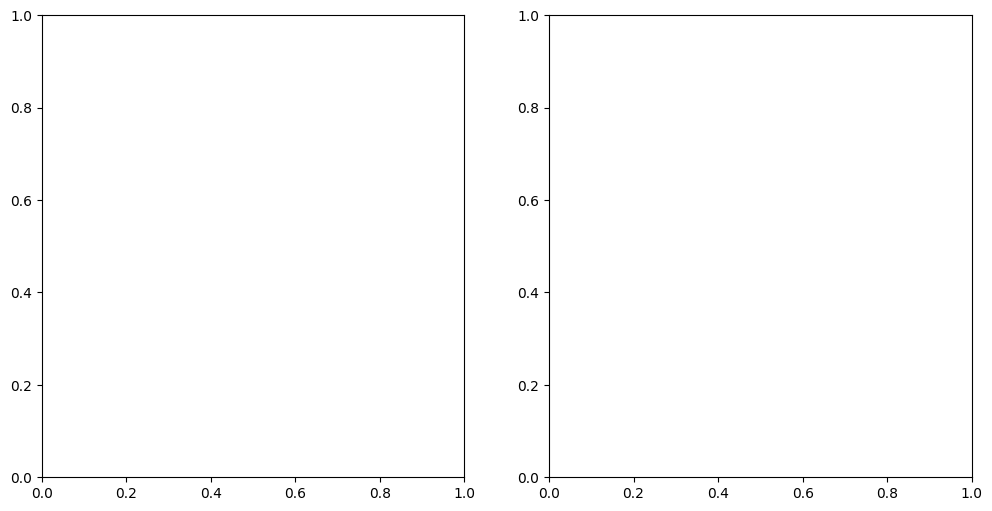

In [34]:
harmonic_many_N(1, [1000], 1)
# basically any time the asymmetry condition is not satisfied, there's no asymmetry, which is good
# if the condition is satisfied, there's sometimes asymmetry - inconclusive and runs into numerical issues sometimes
# with the asymmetry changing based on the number of points

k^2 condition cutoff:  0.0010119288512538814
100 400
[-3.89054201e-05 -3.89034536e-05 -3.89009993e-05 -3.88965259e-05
 -3.88911470e-05 -3.88845975e-05 -3.88768222e-05 -3.88678773e-05
 -3.88577625e-05 -3.88464588e-05 -3.88339503e-05 -3.88202543e-05
 -3.88053738e-05 -3.87893292e-05 -3.87720865e-05 -3.87536541e-05
 -3.87340472e-05 -3.87132548e-05 -3.86912791e-05 -3.86681298e-05
 -3.86438021e-05 -3.86182896e-05 -3.85916118e-05 -3.85637628e-05
 -3.85347421e-05 -3.85045494e-05 -3.84731724e-05 -3.84406676e-05
 -3.84070020e-05 -3.83721338e-05 -3.83361253e-05 -3.82989644e-05
 -3.82606467e-05 -3.82211739e-05 -3.81805510e-05 -3.81387796e-05
 -3.80958661e-05 -3.80518109e-05 -3.80066166e-05 -3.79602855e-05
 -3.79128205e-05 -3.78642215e-05 -3.78144954e-05 -3.77636449e-05
 -3.77116725e-05 -3.76585845e-05 -3.76043796e-05 -3.75490615e-05
 -3.74926330e-05 -3.74351006e-05 -3.73764668e-05 -3.73167348e-05
 -3.72559083e-05 -3.71939914e-05 -3.71309876e-05 -3.70668999e-05
 -3.70017324e-05 -3.69354889e-05 -3.6

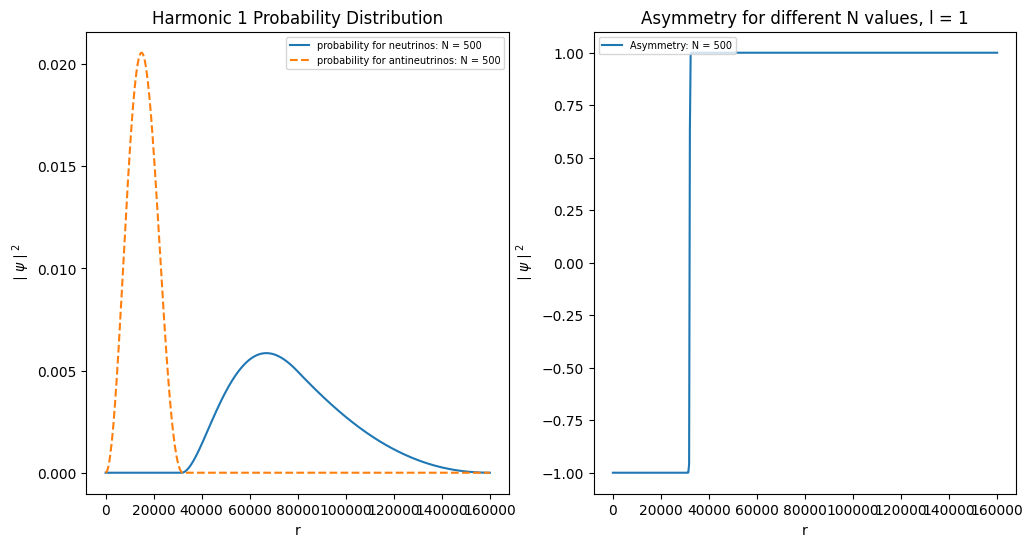

In [ ]:
harmonic_many_N(1, [500], 1)

k^2 condition cutoff:  0.0010119288512538814
300 1200
[6.39666997e-06 1.06203182e-05 1.47103649e-05 1.54080529e-05
 2.06689224e-05 2.35542764e-05 2.48845700e-05 2.63876664e-05
 3.23995201e-05 3.26437407e-05 3.44964352e-05 3.67256494e-05
 3.91780007e-05 4.32983421e-05 4.34408857e-05 4.55993952e-05
 4.79052651e-05 4.99196193e-05 5.20560605e-05 5.34297596e-05
 5.70666814e-05 5.73216457e-05 5.87880283e-05 6.30631611e-05
 6.35287392e-05 6.61230606e-05 6.61849765e-05 6.81911546e-05
 6.96430211e-05 7.31120738e-05 7.33955685e-05 7.75968211e-05
 7.95903429e-05 8.04343612e-05 8.10995866e-05 8.12310574e-05
 8.19486904e-05 8.48628603e-05 8.76844119e-05 9.19665866e-05
 9.22251617e-05 9.22689702e-05 9.56941072e-05 9.60953000e-05
 9.82721786e-05 9.84762830e-05 9.86518717e-05 1.00324650e-04
 1.03574574e-04 1.07369749e-04 1.08298641e-04 1.08544150e-04
 1.09437856e-04 1.11917936e-04 1.12428406e-04 1.15405392e-04
 1.16840023e-04 1.17556606e-04 1.19733433e-04 1.20885911e-04
 1.21203875e-04 1.24610768e-04 

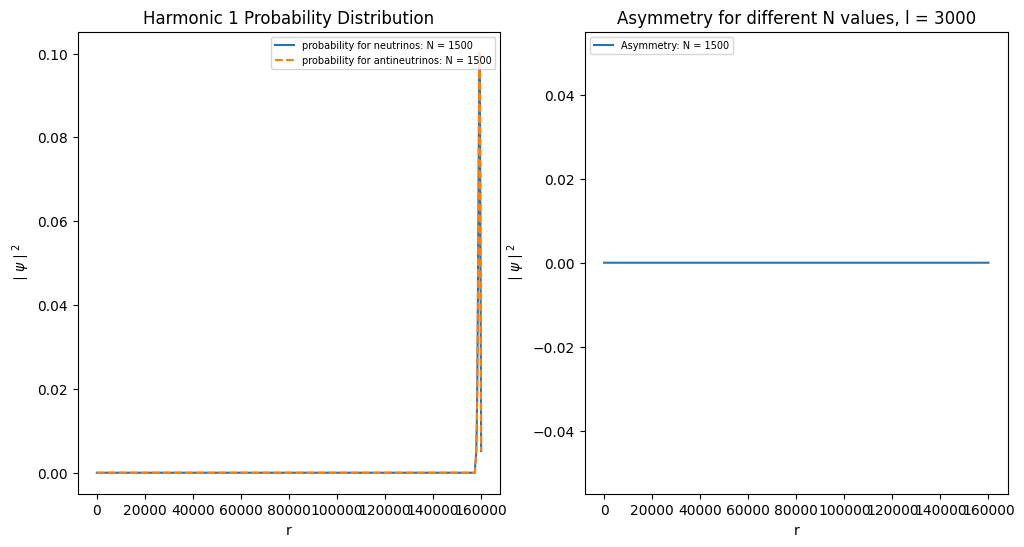

In [ ]:
harmonic_many_N(1, [1500], 3000)
# for the real physical constants, everything gets pushed to the end around l = 1E7
# this would be when our simulation starts to break down
# this is independent of how wide we make the grid (holding the radius of the earth constant)

In [489]:
def harmonic_sum(N, l_max, increment):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    lowest_eigenval = False
    target_E = .01
    kr = target_E * distance
    

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(0, int(l_max), increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        
        # print(f'neutrino energy {n}:', E_pos[n-1])
        # print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        # sum_psi_nu += psi_nu[n-1]
        # sum_psi_antinu += psi_antinu[n-1]

        
        # Filter the eigenvalues, only adding the one for each l value closest to 1E-8
        min_diff_nu = np.inf
        min_diff_antinu = np.inf
        closest_psi_nu = None
        closest_psi_antinu = None
        
        

        for i, E in enumerate(E_pos):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_nu:
                    min_diff_nu = diff
                    closest_psi_nu = psi_nu[i]
                    closest_E_nu = E
                   

        for i, E in enumerate(E_neg):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_antinu:
                    min_diff_antinu = diff
                    closest_psi_antinu = psi_antinu[i]
                    closest_E_antinu = E
                    

        if closest_psi_nu is not None and closest_psi_antinu is not None:
            sum_psi_nu += closest_psi_nu
            print(f'neutrinos: l = {l}, E = {closest_E_nu}')
            sum_psi_antinu += closest_psi_antinu
            print(f'antineutrinos: l = {l}, E = {closest_E_antinu}')
        
        if E_pos[0] > 1.1 * target_E and E_neg[0] > 1.1 * target_E and lowest_eigenval == False:
            print(f"lowest nu eigenvalue is {E_pos[0]}\n lowest antinu eigenvalue is {E_neg[0]}")
            lowest_eigenval = True
            

        

    sum_psi_nu_normalized = normalize(sum_psi_nu)
    sum_psi_antinu_normalized = normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    

    return sum_psi_nu_normalized, sum_psi_antinu_normalized, N, l_max, increment, target_E



In [492]:
psi_nu_normalized, psi_antinu_normalized, N, l_max, increment, target_E = harmonic_sum(1200, 16000, 75)

213.33333333333334 l values remaining
212.33333333333334 l values remaining
211.33333333333334 l values remaining
neutrinos: l = 150, E = 0.010436142446317732
antineutrinos: l = 150, E = 0.009832914321055248
210.33333333333334 l values remaining
neutrinos: l = 225, E = 0.009995405851272976
antineutrinos: l = 225, E = 0.010563882915594845
209.33333333333334 l values remaining
neutrinos: l = 300, E = 0.009787347179270779
antineutrinos: l = 300, E = 0.009793321672418132
208.33333333333334 l values remaining
neutrinos: l = 375, E = 0.010145645765094524
antineutrinos: l = 375, E = 0.010230679959678765
207.33333333333334 l values remaining
neutrinos: l = 450, E = 0.009977441248286954
antineutrinos: l = 450, E = 0.009780124072020266
206.33333333333334 l values remaining
neutrinos: l = 525, E = 0.009860372558587465
antineutrinos: l = 525, E = 0.010091049775562539
205.33333333333334 l values remaining
neutrinos: l = 600, E = 0.010075115627272813
antineutrinos: l = 600, E = 0.009773525264682078


In [437]:
def harmonic_sum_graphing(sum_psi_nu_normalized, sum_psi_antinu_normalized, r_values, N, l_max, increment, target_E):
    
    asym_normalized = []
    asym_over_delta = []
    
    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color = 'blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color = 'green', label='Sum for antineutrinos')

    # Plot the asymmetry
    for j in range(0, len(r_values)):
        asym_over_delta.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(m * U / target_E))
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym_normalized.append(0)
        else:
            asym_normalized.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    ax2.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax3.plot(r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$', fontsize=15)
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of k^2 ~ {target_E} for \nfirst {l_max} l values, increment of {increment}')
    ax1.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')    
    ax2.set_title(f'Asymmetry for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax2.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    print(asym_normalized)

    ax3.set_xlabel('r')
    ax3.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax3.set_yscale('linear')
    ax3.set_xscale('linear')
    ax3.set_title(f'Asymmetry over delta for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax3.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R



    # Display legend
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

    fig, (ax5, ax4) = plt.subplots(1, 2, figsize=(18, 6))
    

    ax5.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax5.set_xlabel('r')
    ax5.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax5.set_yscale('linear')
    ax5.set_xscale('linear')    
    ax5.set_title(f'Zoomed Asymmetry around R = {R}')
    ax5.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    ax5.set_xlim(.8 * R, 1.2 * R)

    ax4.plot(r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}')
    ax4.set_xlabel('r')
    ax4.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=14)  # Increase font size
    ax4.set_yscale('linear')
    ax4.set_xscale('linear')
    ax4.set_title(f'Zoomed Asymmetry over delta around R = {R}')
    # ax4.set_ylim(-.5E-9, .5E-9)

    # Set x-limits to zoom in around R
    ax4.set_xlim(.8 * R, 1.2 * R)
    ax4.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    


    # Display legend
    ax4.legend()
    ax5.legend()

    plt.savefig('1D_plots/zoomed_asymmetry_over_delta.png')
    plt.show()
    

[-0.999999978106363, -0.999999978106363, -0.9999999780026066, -0.9999999775733562, -0.9999999765380279, -0.9999999744633283, -0.9999999705461932, -0.9999999630341345, -0.9999999473627359, -0.9999999084361424, -0.999999772801936, -0.9999987419208384, 0.2268976624342379, 0.9999991895361818, 0.9997362042230653, -0.9962089877069819, -0.9999999975508096, -0.9999999995719757, 0.9999999808342449, 0.9999998082262105, 0.9999958659227294, 0.3887204883917544, -0.9999716386965343, -0.99999218970876, -0.9901919893294566, 0.6887969786330049, 0.39949912590933045, -0.026285058879598058, 0.39915826149381634, 0.7012634522329401, 0.8800413141227846, 0.609101727237687, 0.32829642044399554, -0.027695062550078267, 0.32795497272123975, 0.608135097122496, 0.784014176100112, -0.9999486483219716, -0.9997623609085936, 0.3441281657512179, 0.9999334871318103, 0.9999854901553955, 0.6464683068260353, -0.9998933676428424, -0.9999985193661081, -0.9676745182963075, 0.9964723936116393, 0.99986208830978, 0.38871422038630

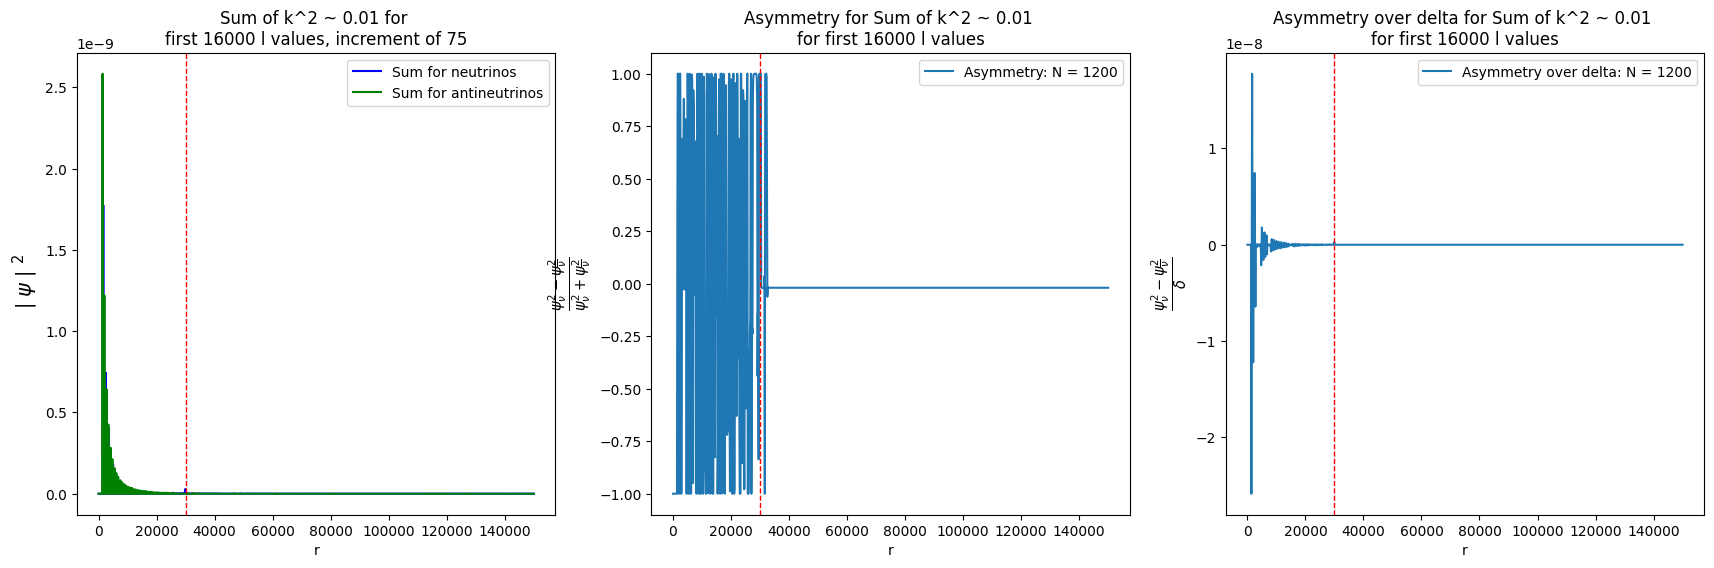

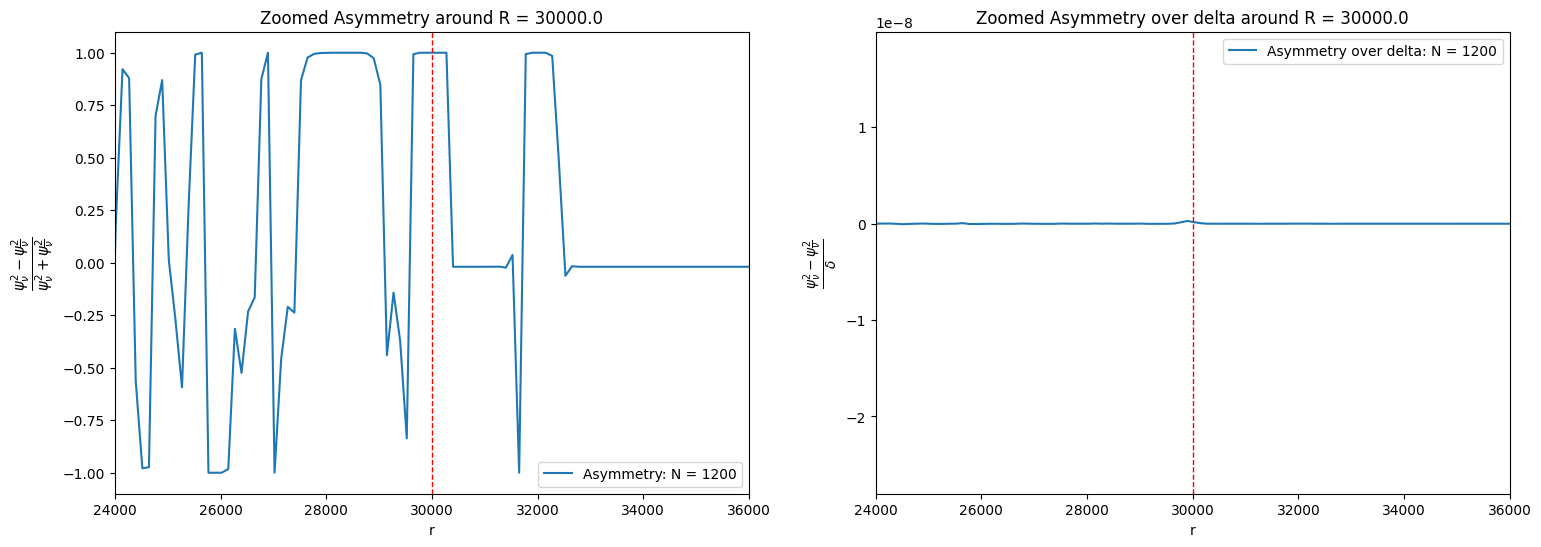

In [493]:
harmonic_sum_graphing(psi_nu_normalized, psi_antinu_normalized, r_values, N, l_max, increment, target_E)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.999999999823186, -0.9999999998699443, -0.9999999717304543, -0.9888400914958188, -0.9978940048924791, -0.9407109876226204, 0.9963175431867676, -0.999998178891225, -0.37721603652953, -0.23828440674977724, -0.30710406630572384, -0.1938920735734179, -0.8457223600529298, 0.4522839805959955, -0.4429401771315861, -0.46012598903233315, -0.9654746723977715, 0.012867343263886897, -0.9972512797494832, 0.9836541401412122, 0.2633190651196347, -0.9977489700539868, 0.9922236208485313, -0.9999775036801866, -0.4026329927198318, 0.006440052627945376, -0.4389315201550176, 0.04237892761131506, -0.9817520556577184, 0.8686067963294452, -0.5834595242309794, -0.6012896347150846, 0.1151631102864206, 0.022775257558620296, -0.9967394927241839, 0.9578783803136731, 0.34698237254021946, -0.996095413682324

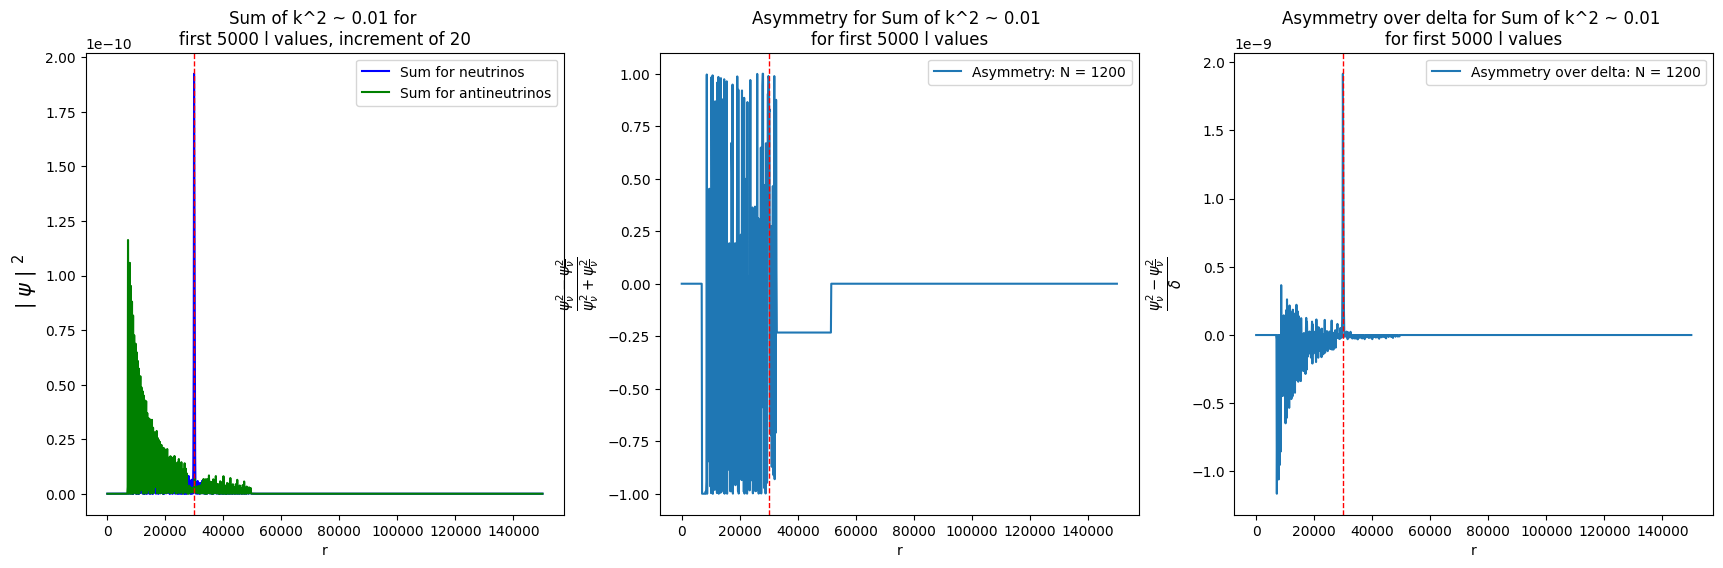

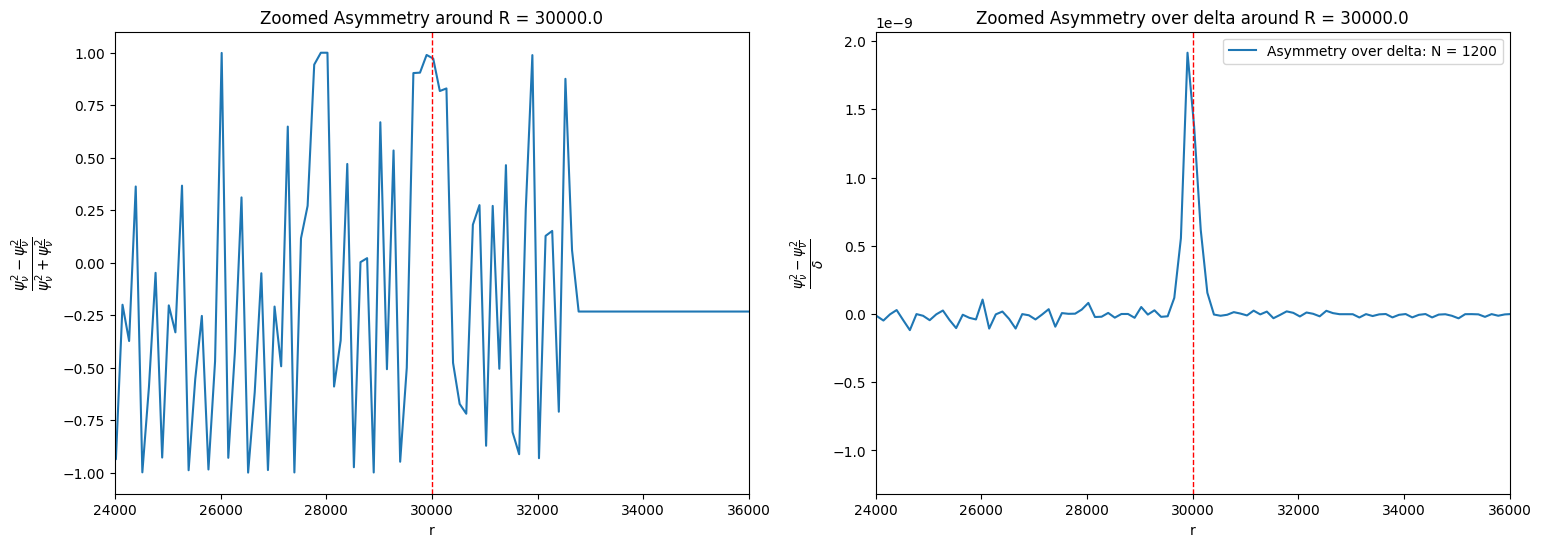

In [436]:
harmonic_sum_graphing(psi_nu_normalized, psi_antinu_normalized, r_values, N, l_max, increment, target_E)

In [ ]:
def accurate_eigenvalues(N, l_max, increment, sum_psi_nu=None):
    r_values = np.linspace(0.001, distance, N)
    if sum_psi_nu is None:
        sum_psi_nu = np.zeros_like(r_values)

    for l in range(0, l_max, increment):
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        psi_nu = psi_nu.T
        for i, E in enumerate(E_pos):
            if 1e-9 < abs(E) < 1e-7:
                # if there's naturally an eigenvalue in the range, add its psi to the graph
                sum_psi_nu += psi_nu[i]
            else:
                print('recursion')
                sum_psi_nu = accurate_eigenvalues(N*10, l_max, increment, sum_psi_nu)


    return sum_psi_nu

accurate_eigenvalues(500, 100, 1)

recursion


KeyboardInterrupt: 

In [ ]:
# define the potentials, treating it for now as a 1D step function


def potential_nu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        # it's plus delta because -mU = + delta/k^2
        V_eff_in = kprime_nu**2 + 2 * delta * kprime_nu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))


        # if i < 3:
        #     H[i,i] = 1E20        
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
            #print("V_eff_in: ", V_eff_in)
        else:
            H[i,i] = V_eff_out
            #print("V_eff_out: ", V_eff_out)
    #print("nu: \n",H)

    return H



def potential_antinu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        global V_eff_in_neg, V_eff_out_neg
        # inside the earth:
        V_eff_in_neg = kprime_antinu**2 - 2 * delta  * kprime_antinu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out_neg = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))

        # if i < 3:
        #     H[i,i] = 1E20
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
            #print("V_eff_in_neg: ", V_eff_in_neg)
        else:
            H[i,i] = V_eff_out_neg
            #print("V_eff_out_neg: ", V_eff_out_neg)
    #print("antinu: \n",H)
    return H

potential_nu(1000, np.linspace(.01, distance, 1000), 10)
potential_antinu(1000, np.linspace(.01, distance, 1000), 1E10)

NameError: name 'kprime_nu' is not defined

In [ ]:
# create the equation to be solved
def Hamiltonian_nu(N, r, l):
    H = second_deriv(N, distance) +  (2/r) * first_deriv(N, distance) + potential_nu(N,r, l)
    return H

def Hamiltonian_antinu(N, r, l):
    H = second_deriv(N, distance) + (2/r) *  first_deriv(N, distance) + potential_antinu(N,r, l)
    return H


-1099999.99999999
-1099999.99999999
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

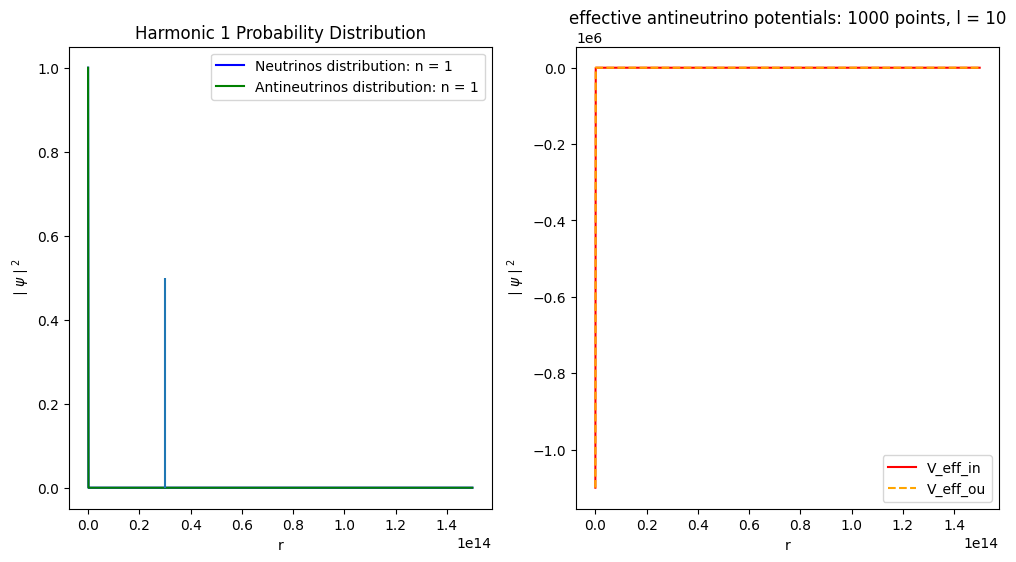

In [ ]:
# function to graph the nth harmonic
#try solving equation 25 instead
# IGNORE THIS CHUNK FOR NOW - THIS IS THE EQUATION 11 STUFF WHICH ISN'T WORKING PROPERLY. THE EQUATION 25 STUFF BELOW IS (KINDA) WORKING

# fix my 2mU to delta definition - it's wrong (tried fixing it make sure its right)

def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(.01, distance, N)
    #might try using eig instead of eigh because the matrices are no longer symmetric
    E_pos, psi_nu = np.linalg.eig(potential_nu(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eig(potential_antinu(N, r_values, l))
    print(E_pos[0])
    print(E_neg[0])

    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(psi_nu[0])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    ax1.plot(r_values, np.abs(psi_nu[n-1])**2, color = 'blue', label=f'Neutrinos distribution: n = {n}') # graphing numerically
    ax1.plot(r_values, np.abs(psi_antinu[n-1])**2, color = 'green', label=f'Antineutrinos distribution: n = {n}') # graphing numerically

    asymmetry = (np.abs(psi_nu[n-1])**2 - np.abs(psi_antinu[n-1])**2)# / (np.abs(psi_nu[n-1])**2 + np.abs(psi_antinu[n-1])**2)
    print("Asymmetry;", asymmetry)
    

    # Plot the asymmetry on the second subplot
    ax2.plot(r_values, kprime_antinu**2 * (1 - 2 * delta - (l * (l + 1))/(kprime_antinu**2 * r_values**2)), color='red', label='V_eff_in') # graphing numerically
    ax2.plot(r_values, k**2 * (1  - (l * (l + 1))/(k**2 * r_values**2)), color='orange', label='V_eff_ou', linestyle = '--') # graphing numerically
    
    # graph the potential on the same plot
    ax1.vlines(3E13, ymin = 0, ymax=.5)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'effective antineutrino potentials: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()



# harmonic(1, 4000, l=1E8)
harmonic(1, 1000, l=10)
# harmonic(1, 4000, l=1E12)
# harmonic(1, 5000, l=1E8)
# harmonic(1, 5000, l=1E10)
# harmonic(1, 5000, l=1E12)
# harmonic(1, 6000, l=1E8)
# harmonic(1, 6000, l=1E10)
# harmonic(1, 6000, l=1E12)